### DATU SAGATAVOŠANA

In [ ]:
# BrambleXu. aspect term extraction. Tiešsaiste. GitHub: 11.09.2018. Pieejams: https://github.com/BrambleXu/aspect-term-extraction/tree/master. [skatīts 2025-03-23].

def soup2dict(sentence_nodes):
    sentences = []
    i = 0
    for n in sentence_nodes:
        i += 1
        sentence = {}
        aspect_term = []
        sentence['id'] = i
        sentence['text'] = n.find('text').string
        if n.find('Opinions'):
            for c in n.find('Opinions').contents:
                if c.name == 'Opinion':
                    if c['target'] not in aspect_term:
                        aspect_term.append(c['target'])

        sentence['aspect'] = aspect_term
        sentences.append(sentence)

    return sentences

In [ ]:
!pip install stanza

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 72.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 878.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 29.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12

In [ ]:
import stanza
stanza.download("lv")
nlp = stanza.Pipeline("lv", processors="tokenize,pos,lemma")
# OpenAI. GPT-4o. Uzvedne: vai manā kodā labāk ieviest tikai lemmatizāciju un kompozītvārdu atpazīšanu vai tikai lemmatizāciju vai tikai kompozītvārdu atpazīšanu? https://chatgpt.com/ [izmantots 2025-04-15]
def split2words(s_text):
    doc = nlp(s_text)
    words = [word.lemma.lower() for sent in doc.sentences for word in sent.words]
    return words

INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Downloading default packages for language: lv (Latvian) ...


INFO:stanza:Downloaded file to /root/stanza_resources/lv/default.zip
INFO:stanza:Finished downloading models and saved to /root/stanza_resources
INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Loading these models for language: lv (Latvian):
| Processor | Package       |
-----------------------------
| tokenize  | lvtb          |
| pos       | lvtb_nocharlm |
| lemma     | lvtb_nocharlm |

INFO:stanza:Using device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Done loading processors!


In [ ]:
def tagging_IOB(s, aspects):
    tags = ['O'] * len(s)

    lemmatized_aspects = [split2words(aspect) for aspect in aspects]

    for aspect_tokens in lemmatized_aspects:
        asp_len = len(aspect_tokens)
        for i in range(len(s) - asp_len + 1):
            if s[i:i+asp_len] == aspect_tokens:
                tags[i] = 'B'
                for j in range(1, asp_len):
                    tags[i+j] = 'I'

    return tags

In [ ]:
def dict2df(sentences):
    data_frames = []
    data = pd.DataFrame()
    for s in sentences:
        sentence = {
            'Sentence #': s['id'],
            'Word': split2words(s['text']),
        }
        aspects = [a.lower() for a in s.get('aspect', [])]
        sentence['Tag'] = tagging_IOB(sentence['Word'], aspects) if aspects else ['O'] * len(sentence['Word'])
        sentence_df = pd.DataFrame(sentence)
        data_frames.append(sentence_df)

    data = pd.concat(data_frames, ignore_index=True)
    return data

In [ ]:
def read_data(file_path):
    # 1 raw data to soup
    soup = None
    with open(file_path, "r", encoding="utf-8") as f:
        soup = BeautifulSoup(f.read().strip(), "lxml-xml")
    if soup is None:
        raise Exception("Can't read xml file")
    sentence_nodes = soup.find_all("sentence")

    # 2  convert soup object to a list of dictionaries
    sentences = soup2dict(sentence_nodes)

    # 3 list to dataframe
    data = dict2df(sentences)

    return data

In [ ]:
from google.colab import files
import re
import numpy as np
import pandas as pd
from pathlib import Path
from bs4 import BeautifulSoup
# OpenAI. ChatGPT o3-mini-high. Uzvedne: izmaini šo koda gabalu tā, lai tas darbotos google colab vidē https://chatgpt.com/ [izmantots 2025-03-23]
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
data = read_data(file_name)
data.tail()

Saving LVtestGOLD_1.xml to LVtestGOLD_1.xml


,Sentence #,Word,Tag
7237,658,iekļaut,O
7238,658,michelin,O
7239,658,restorāns,O
7240,658,ceļvedis,O
7241,658,!,O


In [ ]:
save_file = Path('test.csv')
data.to_csv(save_file, index=False)

### LSTM UN BILSTM APMĀCĪŠANA

In [ ]:
# BrambleXu. aspect term extraction. Tiešsaiste. GitHub: 11.09.2018. Pieejams: https://github.com/BrambleXu/aspect-term-extraction/tree/master. [skatīts 2025-03-23].
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from pathlib import Path
from tensorflow.keras.metrics import Accuracy
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


In [ ]:
data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')

In [ ]:
data = data_train
# Save all words as a list
words = list(set(data['Word'].values))
n_words = len(words)

tags = list(set(data["Tag"].values))
n_tags = len(tags)

max_len = 75
word2idx = {w: i + 1 for i, w in enumerate(words)}
n_words = len(word2idx)
# word2idx['<unk>'] = len(word2idx) + 1
tag2idx = {t: i + 1 for i, t in enumerate(tags)}
tag2idx['<pad>'] = 0
n_tags = len(tag2idx) # Due to <pad>, here total tag number is from 17 to 18

In [ ]:
# Sentence class
class SentenceGetter(object):

    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),
#                                                            s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

getter = SentenceGetter(data)
sentences = getter.sentences # get all sentences

# Word2inx & Padding for X
X = [[word2idx[w[0]] for w in s] for s in sentences]
X_train = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=0)

# Word2inx & Padding for y
y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=0)

# Get one-hot labels
y_train = [to_categorical(i, num_classes=n_tags) for i in y]

print(tag2idx)
print(len(X_train))
print(len(y_train))

{'B': 1, 'I': 2, 'O': 3, '<pad>': 0}
2000
2000


<ipython-input-16-49621940d6e8>:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.grouped = self.data.groupby("Sentence #").apply(agg_func)


In [ ]:
# OpenAI. ChatGPT o3-mini-high. Uzvedne: kā var ieviest manā kodā klašu svarus? https://chatgpt.com/ [izmantots 2025-03-26]
y_train = np.array(y_train)
y_train_int = np.argmax(y_train, axis=-1)
class_weight_dict_idx = {
    tag2idx['O']: 1.0,
    tag2idx['I']: 10.0,
    tag2idx['B']: 10.0
}
print(tag2idx)

import numpy as np
sample_weight = np.ones((y_train_int.shape[0], y_train_int.shape[1]), dtype='float32')
for i in range(y_train_int.shape[0]):
    for j in range(y_train_int.shape[1]):
        cls_idx = y_train_int[i,j]
        if cls_idx in class_weight_dict_idx:
            sample_weight[i,j] = class_weight_dict_idx[cls_idx]
        else:
            sample_weight[i,j] = 0.0


{'B': 1, 'I': 2, 'O': 3, '<pad>': 0}


In [ ]:
# GeeksforGeeks. Long short-term memory (LSTM) RNN in Tensorflow. Tiešsaiste. GeeksforGeeks: 25.02.2025. Pieejams: https://www.geeksforgeeks.org/long-short-term-memory-lstm-rnn-in-tensorflow/. [skatīts 2025-03-23].

# OpenAI. ChatGPT o3-mini-high. Uzvedne: par pamatu ņēmu kodu no šī avota (https://github.com/BrambleXu/aspect-term-extraction/blob/master/notebooks/bi-lstm-crf.ipynb).
# ko vari ieteikt, lai varētu uzlabot manu kodu? jo modelis arī apmācās ļoti lēni, salīdzinājumā ar github repositorija autora rezultātiem, un metriku rezultāti manā
# gadījumā arī ir zemi https://chatgpt.com/ [izmantots 2025-03-24]
input_layer = Input(shape=(max_len,))
model = Embedding(input_dim=len(word2idx) + 1,
                  output_dim=200,
                  input_length=max_len,
                  mask_zero=True,
                  trainable=True)(input_layer)
model = LSTM(units=128, return_sequences=True, recurrent_dropout=0.1)(model) #, recurrent_dropout=0.1
out = TimeDistributed(Dense(n_tags, activation="softmax"))(model)
model = Model(input_layer, out)
model.compile(optimizer="adam",
              loss="categorical_crossentropy", #custom_loss
              metrics=["accuracy"], run_eagerly=True)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 75)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 75, 200)   │    582,600 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 75)        │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 75, 128)   │    168,448 │ embedding[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 75, 4)     │        516 │ lstm[0][0],       │
│ (TimeDistributed)   │                   │            │ not_equal[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 751,564 (2.87 MB)

 Trainable params: 751,564 (2.87 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# OpenAI. ChatGPT o3-mini-high. Uzvedne: tagad nepieciešams sagatavot kodu ar BiLSTM algoritmu, es tev iedošu savu tagadējo kodu ar tagadējiem rezultātiem, nepieciešamības
# pēc veic labojumus un sniedz ieteikumus https://chatgpt.com/ [izmantots 2025-03-27]
input_layer = Input(shape=(max_len,))
model = Embedding(input_dim=len(word2idx) + 1,
                  output_dim=300,
                  input_length=max_len,
                  mask_zero=True)(input_layer)
model = Bidirectional(LSTM(units=128, return_sequences=True, recurrent_dropout=0.1))(model)
model = Dropout(0.2)(model)
out = TimeDistributed(Dense(n_tags, activation="softmax"))(model)
model = Model(input_layer, out)
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"], run_eagerly=True)
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 75)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, 75, 300)   │    873,900 │ input_layer_5[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_5         │ (None, 75)        │          0 │ input_layer_5[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 75, 256)   │    439,296 │ embedding_5[0][0… │
│ (Bidirectional)     │                   │            │ not_equal_5[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 75, 256)   │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_5  │ (None, 75, 4)     │      1,028 │ dropout_1[0][0],  │
│ (TimeDistributed)   │                   │            │ not_equal_5[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,314,224 (5.01 MB)

 Trainable params: 1,314,224 (5.01 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 102s 4s/step - accuracy: 0.2135 - loss: 2.2970 - val_accuracy: 0.1837 - val_loss: 1.2818
Epoch 2/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 105s 4s/step - accuracy: 0.1485 - loss: 1.3037 - val_accuracy: 0.1801 - val_loss: 0.8039
Epoch 3/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 132s 3s/step - accuracy: 0.1519 - loss: 0.7795 - val_accuracy: 0.1792 - val_loss: 0.5815
Epoch 4/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 151s 4s/step - accuracy: 0.1560 - loss: 0.5491 - val_accuracy: 0.1814 - val_loss: 0.5485
Epoch 5/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - accuracy: 0.1582 - loss: 0.3977 - val_accuracy: 0.1848 - val_loss: 0.5418
Epoch 6/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 144s 4s/step - accuracy: 0.1552 - loss: 0.3024 - val_accuracy: 0.1848 - val_loss: 0.5615
Epoch 7/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 97s 3s/step - accuracy: 0.1587 - loss: 0.2589 - val_accuracy: 0.1865 - val_loss: 0.6257
Epoch 8/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - accuracy: 0.1615 - loss: 0.2274 - val_accuracy: 0.1867 - val

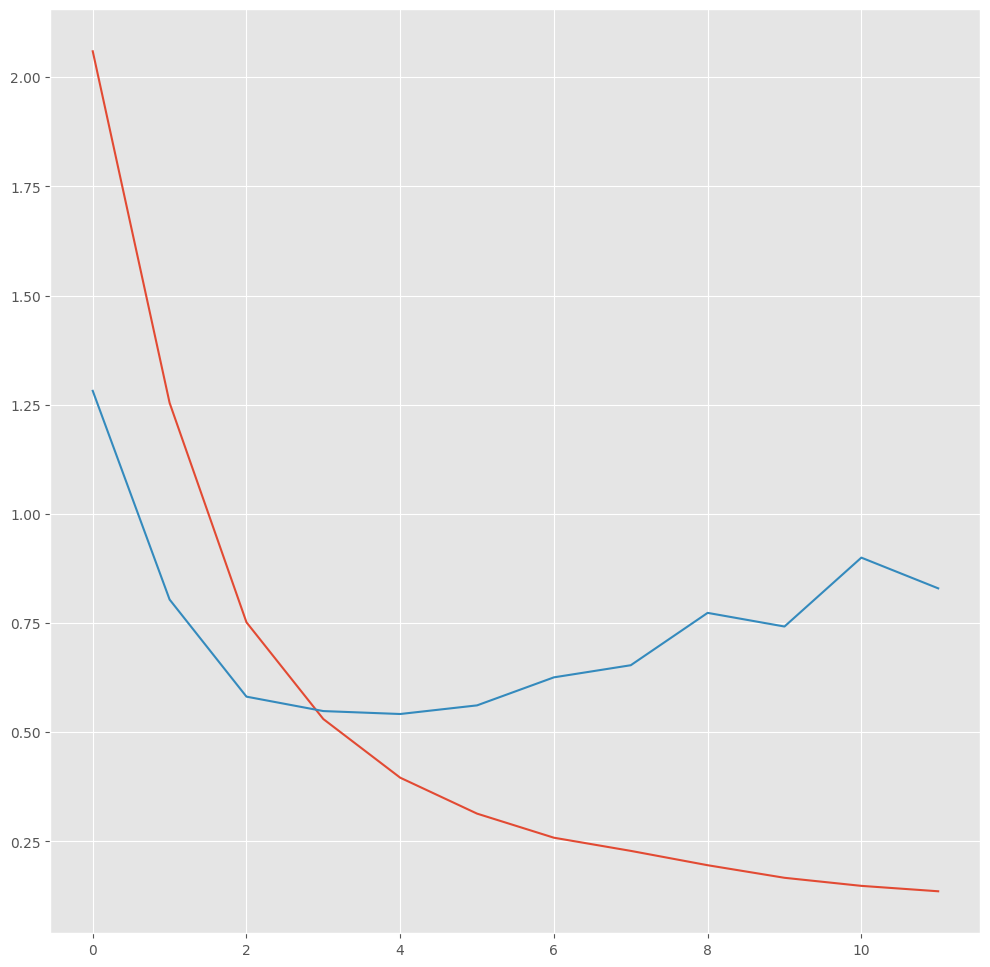

In [ ]:
history = model.fit(X_train, np.array(y_train), batch_size=64, epochs=12,
                    validation_split=0.1, sample_weight=sample_weight, verbose=1)
hist = pd.DataFrame(history.history)
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.show()

### LSTM UN BILSTM PĀRBAUDĪŠANA

In [ ]:
data = data_test
getter = SentenceGetter(data)
sentences = getter.sentences # get all sentences

# Word2inx & Padding for X
X = [[word2idx.get(w[0], 0) for w in s] for s in sentences]
X_test = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=0)

# Word2inx & Padding for y
y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx['<pad>'])

# Get one-hot labels
y_test = [to_categorical(i, num_classes=n_tags) for i in y]

<ipython-input-16-49621940d6e8>:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.grouped = self.data.groupby("Sentence #").apply(agg_func)


In [ ]:
print(sentences[1])
print(X_test[1])
print(np.argmax(y_test[1], -1))

[('ļoti', 'O'), ('draudzīgs', 'O'), ('cena', 'O'), ('ēdiens', 'B'), ('un', 'O'), ('labs', 'O'), ('vietējs', 'O'), ('alus', 'B'), ('izlase', 'I'), ('.', 'O')]
[1649 1738 1185 2424 1573 2881 1752 1315  350 1146    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0]
[3 3 3 1 3 3 3 1 2 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0]


In [ ]:
# Predictions.
idx2word = {value: key for key, value in word2idx.items()}
idx2tag = {value: key for key, value in tag2idx.items()}
print(idx2tag)

{1: 'B', 2: 'I', 3: 'O', 0: '<pad>'}


In [ ]:
true_all = np.argmax(y_test, -1)
true_all_tags = [[idx2tag[idx] for idx in s if idx!=0] for s in true_all]

p_all = model.predict(np.array(X_test)) # (4796, 75, 18)
p_all= np.argmax(p_all, axis=-1) # (4796, 75)
p_all_tags = [[idx2tag[idx] for idx in s] for s in p_all] # ['B-gpe', 'O', 'O', 'O']

for i, true in enumerate(true_all_tags):
    length = len(true)
    p_all_tags[i] = p_all_tags[i][:length]

p_all_tags = [[x.replace('<pad>', 'O') for x in s] for s in p_all_tags]

print(sentences[3])
print(X_test[3])
print(true_all_tags[3])
print(p_all_tags[3])

21/21 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step
[('perfekts', 'O'), ('apkalpošana', 'B'), (',', 'O'), ('prast', 'O'), ('ieteikt', 'O'), ('lielisks', 'O'), ('ēdiens', 'O'), ('.', 'O')]
[1512 2604  759    0 1090 1647 2424 1146    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0]
['O', 'B', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'B', 'O', 'O', 'O', 'O', 'B', 'O']


In [ ]:
# OpenAI. ChatGPT o3-mini-high. Uzvedne: kā man izlabot kļūdu ValueError: max() arg is an empty sequence šajā koda daļā? https://chatgpt.com/ [izmantots 2025-03-26]
# OpenAI. ChatGPT o3-mini-high. Uzvedne: šo kodu es izmantoju modeļa apmācīšanai ar datu kopu, kas ir paredzēta noskaņojumu noteikšanai aspektiem.
# CSV faili sastāv no teikuma numura, vārda un marķiera, kas apzīmē šī vārda noskaņojumu (2 - pozitīvs, 1 - neitrāls, 0 - negatīvs, O - nav noskaņojuma) https://chatgpt.com/ [izmantots 2025-03-26]
from sklearn.metrics import classification_report

true_flat = []
pred_flat = []
for i in range(len(true_all_tags)):
    true_flat.extend(true_all_tags[i])
    pred_flat.extend(p_all_tags[i])

print(classification_report(true_flat, pred_flat, labels=["B","I","O"]))


              precision    recall  f1-score   support

           B       0.46      0.78      0.58       497
           I       0.29      0.37      0.32       145
           O       0.98      0.92      0.95      6600

    accuracy                           0.90      7242
   macro avg       0.57      0.69      0.62      7242
weighted avg       0.93      0.90      0.91      7242

